#### Calculating the percent share of agriculture in total employment per province for December 2022

###### Data Source: PSA Labor Survey December 2022

In [8]:
import pandas as pd
# import numpy as np

##### Reading CSV file as DF

In [29]:
fp = r"LFS PUF December 2022.CSV"

df = pd.read_csv(fp, usecols=['PUFREG', 'PUFC09_WORK', 'PUFC11A_PROVMUN', 'PUFC15_PKB'],
                 na_values=[' ', '  ', '   ', '    ', '     ', '      '])
df.sample(5)

,PUFREG,PUFC09_WORK,PUFC11A_PROVMUN,PUFC15_PKB
10986,5,NaN,NaN,NaN
4757,3,2.0,NaN,NaN
26617,11,1.0,2505.0,47.0
42330,16,2.0,NaN,NaN
14877,6,1.0,4516.0,84.0


##### Check column data types & DF shape

In [30]:
df.dtypes

PUFREG               int64
PUFC09_WORK        float64
PUFC11A_PROVMUN    float64
PUFC15_PKB         float64
dtype: object

In [31]:
df.shape

(45687, 4)

##### Save to a new DF only rows where work indicator = 1

In [32]:
work_df = df.loc[df['PUFC09_WORK'] == 1]
work_df.sample(5)

,PUFREG,PUFC09_WORK,PUFC11A_PROVMUN,PUFC15_PKB
31509,13,1.0,7404.0,96.0
40914,15,1.0,7010.0,3.0
18053,8,1.0,3708.0,45.0
27240,11,1.0,8601.0,1.0
24542,10,1.0,4301.0,1.0


##### Rename columns and drop work indicator column

In [36]:
col_names = {
    'PUFREG': 'REGION',
    'PUFC11A_PROVMUN': 'PROV_MUN',
    'PUFC15_PKB': 'INDUSTRY'
}

work_df = work_df.rename(columns=col_names)[['REGION', 'PROV_MUN', 'INDUSTRY']]
work_df.sample(5)

,REGION,PROV_MUN,INDUSTRY
30472,13,3905.0,82.0
25536,11,2317.0,68.0
4213,3,4903.0,85.0
12774,6,618.0,1.0
27642,12,4701.0,1.0


##### Parse province out of prov-muni column

In [37]:
# Remove decimal place from prov-muni by converting to int
work_df['PROV_MUN'] = work_df['PROV_MUN'].astype(int)

# Convert to string, pad w/ leading zeroes up to 4 chars,
# then slice out first 2 chars as province code
work_df['PROVINCE'] = work_df['PROV_MUN'].astype(str)\
                      .str.zfill(4).str.slice(0,2)

work_df.sample(5)

,REGION,PROV_MUN,INDUSTRY,PROVINCE
13641,6,3022,47.0,30
41457,16,203,96.0,02
326,1,2819,47.0,28
11913,5,6211,1.0,62
34221,13,7602,78.0,76


##### Group DF by province code

In [40]:
by_prov = work_df.groupby('PROVINCE')
len(by_prov)

87

##### Calculate percent share of agriculture in total employment per province

In [75]:
# Create empty dataframe for aggregated values
agshare_by_prov = pd.DataFrame()

# Iterate over each province
for key, group in by_prov:

    # Create empty series in which to store each calculation
    c = pd.Series()

    # Add region code to series as well
    c['REGION'] = group['REGION'].median().astype(int)

    # Add key (i.e. province code) into series of values
    c['PROVINCE'] = key

    # Count total number of employed (aka length of group)
    c['TOTAL_EMPLOYED'] = group['INDUSTRY'].count()

    # Count number of people employed in agriculture
    c['AGRI_EMPLOYED'] = group.loc[group['INDUSTRY'] < 4]['INDUSTRY'].count()

    # Calculate ratio between agri & total employment
    # and round off values to 2 decimal places
    c['PERCENT_AGRI'] = c['AGRI_EMPLOYED'] / c['TOTAL_EMPLOYED'] * 100
    c['PERCENT_AGRI'] = round(c['PERCENT_AGRI'], 2)

    # Convert series into dataframe and transpose into a row
    row = c.to_frame().transpose()

    # Concatenate new row into agshare_by_prov dataframe
    agshare_by_prov = pd.concat([agshare_by_prov, row], ignore_index=True)

agshare_by_prov = agshare_by_prov.set_index('PROVINCE')
agshare_by_prov

,REGION,TOTAL_EMPLOYED,AGRI_EMPLOYED,PERCENT_AGRI
PROVINCE,,,,
01,14,168,40,23.81
02,16,406,83,20.44
03,16,250,154,61.6
04,6,204,49,24.02
05,5,186,40,21.51
...,...,...,...,...
83,9,271,163,60.15
85,16,78,34,43.59
86,11,182,106,58.24


In [76]:
agshare_by_prov.dtypes

REGION            object
TOTAL_EMPLOYED    object
AGRI_EMPLOYED     object
PERCENT_AGRI      object
dtype: object

<Axes: ylabel='PROVINCE'>

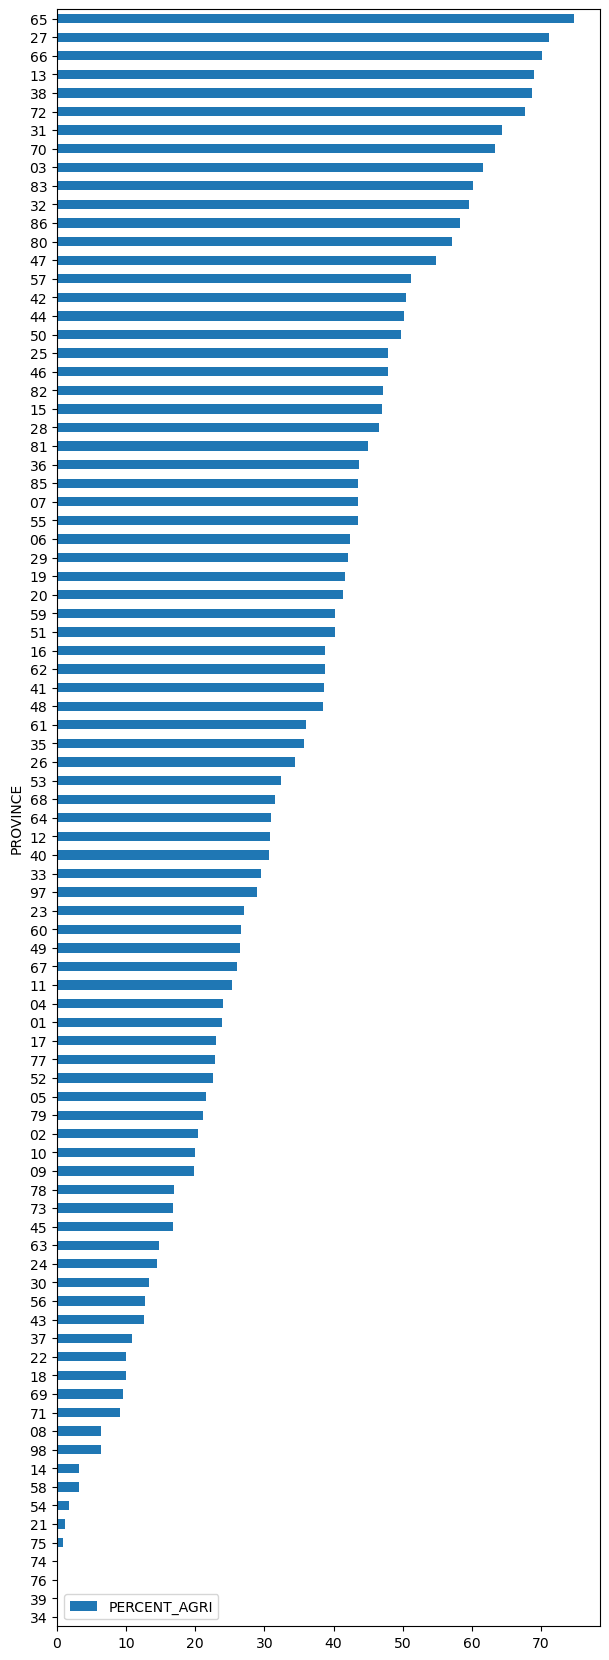

In [78]:
agshare_by_prov[['PERCENT_AGRI']]\
        .sort_values(by='PERCENT_AGRI')\
        .plot(kind='barh', linewidth=2, width=0.5, figsize=(7, 21))

In [80]:
agshare_by_prov.to_csv(r"Agri Share by Province - LFS Dec 2022.csv")